In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import re

In [2]:
modeToUnits = {'thrpt':'ops/ms', 'avgt':'ms/op'}

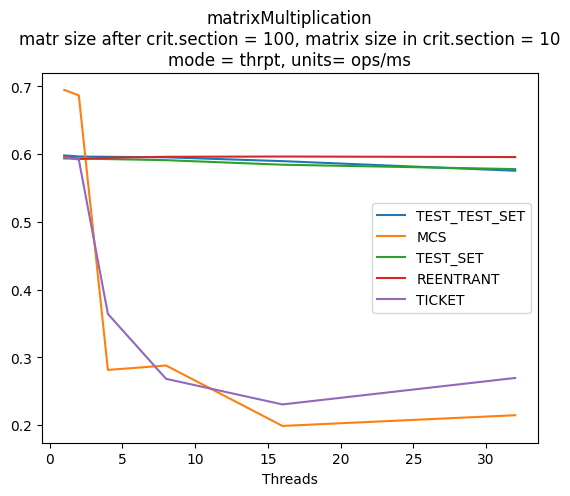

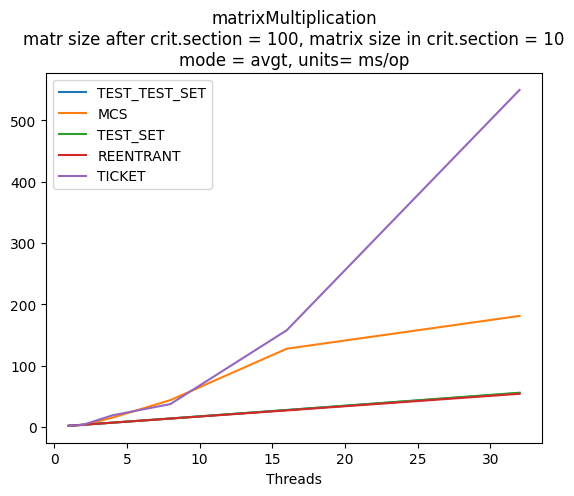

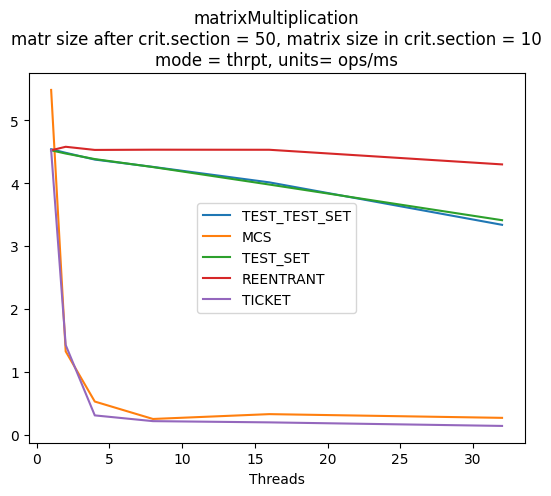

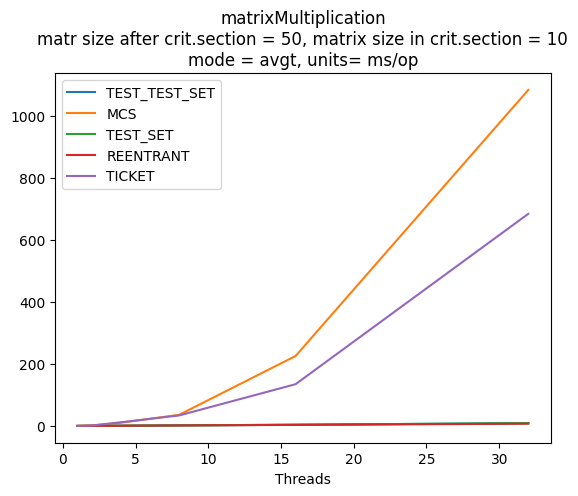

In [12]:
# Бенчмарки сгенерены 11 ноября
# Проверяем с умножением матриц 10*10 внутри крит секции, 50*50 снаружи крит секции
# Проверяем с умножением матриц 10*10 внутри крит секции, 100*100 снаружи крит секции
# количество тредов 1,2,4,8,16,32
ARCHIVE_FOLDER_NAME = 'matr(10,50)(10,100)'
path = os.getcwd() + '/archive/' + ARCHIVE_FOLDER_NAME + '/*.csv'
all_files = glob.glob(path)
df_list = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df_list.append(df)

df = pd.concat(df_list, axis=0, ignore_index=True)
# убираем имена пакетов из бенчмарков
df['Benchmark'] = df['Benchmark'].apply(lambda x : x[x.rfind('.') + 1:]) 
# оставляем все бенчмарки не из perfnorm профайлера, а также LLC-load-misses
benchmarks = sorted(set(filter(lambda x : (not re.search(':', x)) or re.search('LLC-load-misses', x), df['Benchmark'])))


# оставляем только бенчмарки с матрицей
df_matrix = df[df['Benchmark'].isin(filter(lambda x : re.search('matrixMultiplication', x), benchmarks))].copy()
# берем типы локов
locks = set(df_matrix['Param: lockType'])
# берем режимы (thrpt, avg)
modes = set(df_matrix['Mode'])
# зададим параметры бенчмарка в его названии
df_matrix['Benchmark'] = df_matrix['Benchmark'] + '\n' \
   + 'matr size after crit.section = ' \
     + df_matrix['Param: afterSectionMatrixSize'].astype(str) \
        + ', matrix size in crit.section = ' + df_matrix['Param: inSectionMatrixSize'].astype(str)
for b in sorted(set(df_matrix['Benchmark'])):
    for mode in modes:
        title = b + '\n' +'mode = ' + mode + ', units= ' + modeToUnits[mode]
        ax = plt.axes(title = title)
        for lock in locks:
            df_matrix[(df_matrix['Benchmark'] == b) & (df_matrix['Mode'] == mode) & (df_matrix['Param: lockType'] == lock)]\
              .sort_values(by=['Threads']) \
              .plot(ax=ax, x='Threads', y='Score', label = lock)    
        plt.savefig('pictures/' + ARCHIVE_FOLDER_NAME + '/' + mode + '_' + b + '.png', bbox_inches="tight")       
        plt.show()